In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import pymc3 as pm
import scipy as sp
import pyccl as ccl
import os
import utils
from make_data import MakeData
import getdist
from getdist import plots, MCSamples
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load data

In [2]:
names_planck  = ['H', 'Omega_m', 'sigma8']
labels_planck = ['H', r'\Omega_{\rm{m}}', r'\sigma_{\rm{8}}']

planck1 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_1.txt')
planck2 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_2.txt')
planck3 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_3.txt')
planck4 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_4.txt')

planck_tot = np.concatenate((planck1, planck2, planck3, planck4), axis=0)

planck_params = []
for item in planck_tot:
    planck_params.append([item[29], item[31], item[34]])
planck_params = np.array(planck_params)
planck= MCSamples(samples=planck_params, names = names_planck, labels = labels_planck, label= r'$Planck$ 2018',
                    weights=np.transpose(planck_tot)[0],loglikes=np.transpose(planck_tot)[1])

Removed no burn in


In [3]:
z_max = 1110
res = 200
x_arr = np.linspace(0, np.log(1+z_max), res)
dx = np.mean(np.diff(x_arr))
z_arr = np.exp(x_arr)-1
a_arr = 1./(1+z_arr)

path = '/home/jaimerz/PhD/Growz/data/products'

data_class = MakeData(z_max, res , path)
Planck = data_class.Planck
z_planck = data_class.z_planck
c = data_class.c

DESI_data = data_class.get_DESI(new=True, mode=None)
WFIRST_data = data_class.get_WFIRST(new=True)
CC_data = data_class.get_CC(new=True)
DSS_data = data_class.get_DSS(new=True)
BOSS_data = data_class.get_BOSS(new=True)
eBOSS_data = data_class.get_eBOSS(new=True)
Wigglez_data = data_class.get_Wigglez(new=True)
DS17_data = data_class.get_DS17(new=True)
CMB_data = data_class.get_CMB(new=True)
FCMB_data = data_class.get_FCMB(new=True)

In [4]:
def get_m_s(rows):
    cols = np.transpose(rows)
    means = np.array([])
    sigmas = np.array([])
    for col in cols:
        mean = np.mean(col)
        sigma = np.std(col)
        means = np.append(means, mean)
        sigmas = np.append(sigmas, sigma)
    return means, sigmas

In [5]:
path = '/home/jaimerz/PhD/Growz/data/outputs/'
All = np.load(os.path.join(path,'fixed_eta/All_fixed_eta_100_100/samples.npz'))
All_CMB = np.load(os.path.join(path,'All_CMB_100_100/samples.npz'))
All_CMB_hp = np.load(os.path.join(path,'All_CMB_hp_100_100/samples.npz'))
All_CMB_geo_gro = np.load(os.path.join(path,'All_CMB_geo_gro_100_100/samples.npz'))
All_CMB_full = np.load(os.path.join(path,'All_CMB_full_100_100/samples.npz'))
All_CMB_Xi = np.load(os.path.join(path,'All_CMB_Xi_100_100/samples.npz'))
All_FCMB = np.load(os.path.join(path,'fulls/All_FCMB_100_100/samples.npz'))
SDSS = np.load(os.path.join(path,'fulls/SDSS_1000_2500/samples.npz'))
SDSS_CMB = np.load(os.path.join(path,'fulls/SDSS_CMB_1000_2500/samples.npz'))
Add = np.load(os.path.join(path,'fulls/Add_1000_2500/samples.npz'))
Add_CMB = np.load(os.path.join(path,'fulls/Add_CMB_1000_2500/samples.npz'))
DESI = np.load(os.path.join(path,'fixed_eta/DESI_fixed_eta_100_100/samples.npz'))
DESI_CMB = np.load(os.path.join(path,'fixed_eta/DESI_CMB_fixed_eta_100_100/samples.npz'))
WFIRST_CMB = np.load(os.path.join(path,'fulls/WFIRST_CMB_1000_2500/samples.npz'))

In [6]:
All_mean = np.load(os.path.join(path,'means/All_1000_2500_mean/samples.npz'))
All_CMB_mean = np.load(os.path.join(path,'means/All_CMB_1000_2500_mean/samples.npz'))
All_osc = np.load(os.path.join(path,'oscs/All_1000_2500_osc/samples.npz'))
All_CMB_osc = np.load(os.path.join(path,'oscs/All_CMB_1000_2500_osc/samples.npz'))

In [7]:
labels_dict = {'n': '\eta',
               'l': 'l',
               'H0': 'H_0',
               'H0_gp': 'H_0',
               'omega_m': '\omega_m',
               'omega_b': '\omega_b',
               's80': '\sigma_8',
               'S80': 'S_8',
               'M': 'M'}
names_All = ['n', 'l', 'H0', 'H0_gp',  'omega_m', 'omega_b',  's80', 'S80', 'M']
#ranges = {'l':[0.001, 7], 'omega_b': [0.022, 0.023]}
ranges = {'l':[0.001, 7]}

# Triangle Plots

In [8]:
def make_samples(file, names, ranges, label):
    namess = []
    labels = []
    samples = []
    for name in names:
        if name in file.keys():
            namess.append(name) 
            labels.append(labels_dict[name]) 
            samples.append(file[name]) 
        
    return MCSamples(samples=samples, names=namess, labels=labels, label=label, ranges=ranges)

In [9]:
def make_samples_hp(file, names, ranges, label):
    namess = []
    for name in names:
        if name in file.keys():
            namess.append(name) 
            
    samples = []
    for name in namess:
        samples.append(file[name]) 
    labels = []
    for name in namess:
        labels.append(labels_dict[name])
    return MCSamples(samples=samples, names=namess, labels=labels, label=label, ranges=ranges)

In [10]:
def make_samples_geo_gro(file, names, ranges, label):
    namess = []
    labels = []
    samples = []
    for name in names:
        if name in file.keys():
            namess.append(name) 
            namess.append(labels_dict[name]) 
            samples.append(file[name]) 
        
    return MCSamples(samples=samples, names=namess, labels=labels, label=label, ranges=ranges)

In [23]:
WFIRST_CMB_samples = make_samples(WFIRST_CMB, ['n', 'l', 'H0', 'omega_m',  'omega_b'], ranges, 'WFIRST')
DESI_samples = make_samples(DESI, ['l', 'H0', 'omega_m',  's80', 'S80'], ranges, 'DESI')
DESI_CMB_samples = make_samples(DESI_CMB, ['l', 'H0', 'omega_m',  'omega_b', 's80', 'S80'], ranges, 'DESI+CMB')
All_samples = make_samples(All, ['l', 'H0', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'All')
All_CMB_samples = make_samples(All_CMB, ['n', 'l', 'H0', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'All+CMB')
All_CMB_hp_samples = make_samples(All_CMB_hp, ['H0', 'omega_b', 'omega_m', 's80', 'S80'],
                                      ranges, 'All+CMB_hp')
All_CMB_geo_gro_samples = make_samples(All_CMB_geo_gro, ['n', 'l', 'H0', 'omega_b', 'omega_m', 's80', 'S80'],
                                           ranges, 'All+CMB_geo_gro')
All_CMB_full_samples = make_samples(All_CMB_full, ['omega_b', 'omega_m', 's80'],
                                      ranges, 'All+CMB_full')
All_CMB_Xi_samples = make_samples(All_CMB_Xi, ['H0', 'omega_b', 'omega_m', 's80', 'S80'],
                                      ranges, 'All+CMB_Xi')


SDSS_samples = make_samples(SDSS, ['n', 'l', 'H0', 'omega_m', 'omega_b', 's80', 'S80'], ranges, 'SDSS')
SDSS_CMB_samples = make_samples(SDSS_CMB, ['n', 'l', 'H0', 'omega_m', 'omega_b', 's80', 'S80'], 
                                      ranges, 'SDSS+CMB')
Add_samples = make_samples(Add, ['n', 'l', 'H0', 'omega_m', 's80', 'S80'], ranges, 'Add')
Add_CMB_samples = make_samples(Add_CMB, ['n', 'l', 'H0', 'omega_m', 'omega_b', 's80', 'S80'], 
                                      ranges, 'Add+CMB')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


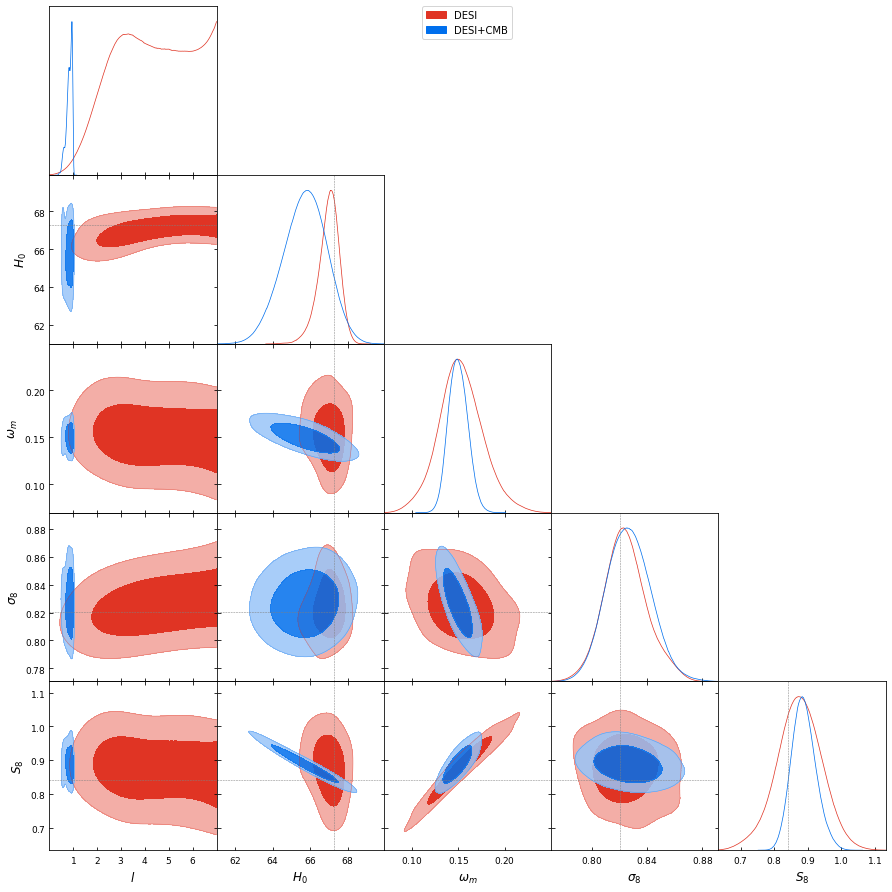

In [76]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_samples, DESI_CMB_samples],
                ['l', 'H0', 'omega_m', 's80', 'S80'],
                filled=True, 
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_b': data_class.cosmo.Omega_b(),
                         'Omega_L': data_class.cosmo.Omega_Lambda(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')

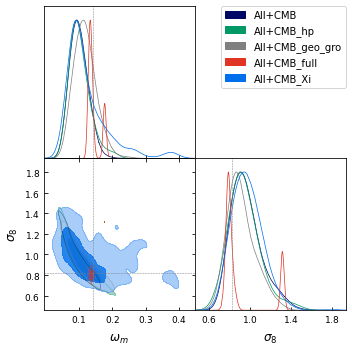

In [25]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([All_CMB_samples, All_CMB_hp_samples, All_CMB_geo_gro_samples, All_CMB_full_samples, All_CMB_Xi_samples],
                ['omega_m', 's80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_b': data_class.cosmo.Omega_b(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         'omega_b': data_class.cosmo.Omega_b()*data_class.cosmo.h()**2,
                         'Omega_L': data_class.cosmo.Omega_Lambda(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')

In [93]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([SDSS_samples, SDSS_CMB_samples],
                ['n', 'l', 'H0', 'omega_m', 'omega_b', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_b': data_class.cosmo.Omega_b(),
                         'Omega_L': data_class.cosmo.Omega_Lambda(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')

Exception: parameter name not found: omega_m

In [94]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([Add_samples, Add_CMB_samples],
                ['n', 'l', 'H0', 'Omega_m', 'Omega_L', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_b': data_class.cosmo.Omega_b(),
                         'Omega_L': data_class.cosmo.Omega_Lambda(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')

Exception: parameter name not found: Omega_m

In [95]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([SDSS_samples, Add_samples, All_samples],
                ['n', 'l', 'H0', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_b': data_class.cosmo.Omega_b(),
                         'Omega_L': data_class.cosmo.Omega_Lambda(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')

Exception: parameter name not found: Omega_m

In [97]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([SDSS_CMB_samples, Add_CMB_samples, All_CMB_samples],
                ['n', 'l', 'H0', 'omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_b': data_class.cosmo.Omega_b(),
                         'Omega_L': data_class.cosmo.Omega_Lambda(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')

Exception: parameter name not found: omega_m

In [98]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([All_CMB_samples, DESI_CMB_samples],
                ['n', 'l', 'H0', 'omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_b': data_class.cosmo.Omega_b(),
                         'Omega_L': data_class.cosmo.Omega_Lambda(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')

Exception: parameter name not found: H0

# Xi

In [26]:
dH_All_CMB_Xi_m, dH_All_CMB_Xi_s = get_m_s(1+All_CMB_Xi['DHz'])

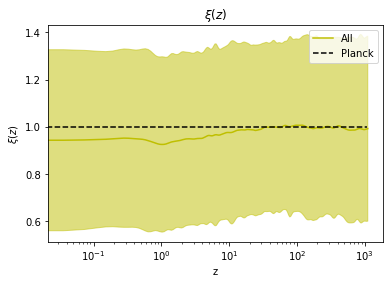

In [31]:
plt.plot(z_arr,  dH_All_CMB_Xi_m, color ='y', label='All')
plt.fill_between(z_arr, dH_All_CMB_Xi_m+dH_All_CMB_Xi_s,
                 dH_All_CMB_Xi_m-dH_All_CMB_Xi_s, color='y', alpha=.5)

plt.plot(z_planck, np.ones_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlabel("z")
plt.ylabel(r"$ \xi(z)$")
plt.title(r"$\xi(z)$")
plt.legend();

# d_H gp 

In [122]:
dH_DESI_m, dH_DESI_s = get_m_s(DESI['DHz'])
dH_DESI_CMB_m, dH_DESI_CMB_s = get_m_s(DESI_CMB['DHz'])
dH_All_m, dH_All_s = get_m_s(All['DHz'])
dH_All_CMB_m, dH_All_CMB_s = get_m_s(All_CMB['DHz'])
dH_All_CMB_hp_m, dH_All_CMB_hp_s = get_m_s(All_CMB_hp['DHz'])
dH_All_CMB_geo_gro_m, dH_All_CMB_geo_gro_s = get_m_s(All_CMB_geo_gro['DHz'])
dH_All_CMB_full_m, dH_All_CMB_full_s = get_m_s(All_CMB_full['DHz'])
dH_All_FCMB_m, dH_All_FCMB_s = get_m_s(All_FCMB['DHz'])
dH_SDSS_m, dH_SDSS_s = get_m_s(SDSS['DHz'])
dH_SDSS_CMB_m, dH_SDSS_CMB_s = get_m_s(SDSS_CMB['DHz'])
dH_Add_m, dH_Add_s = get_m_s(Add['DHz'])
dH_Add_CMB_m, dH_Add_CMB_s = get_m_s(Add_CMB['DHz'])

#dH_All_mean_m, dH_All_mean_s = get_m_s(All_mean['DHz'])
#dH_All_CMB_mean_m, dH_All_CMB_mean_s = get_m_s(All_CMB_mean['DHz'])
dH_All_osc_m, dH_All_osc_s = get_m_s(All_osc['DHz'])
dH_All_CMB_osc_m, dH_All_CMB_osc_s = get_m_s(All_CMB_osc['DHz'])

Planck = data_class.Planck
z_planck = data_class.z_planck

KeyError: 'DHz is not a file in the archive'

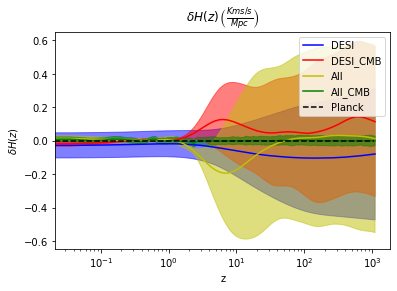

In [101]:
plt.plot(z_arr,  dH_DESI_m, color ='b', label='DESI')
plt.fill_between(z_arr, dH_DESI_m+dH_DESI_s,
                 dH_DESI_m-dH_DESI_s, color='b', alpha=.5)
plt.plot(z_arr,  dH_DESI_CMB_m, color ='r', label='DESI_CMB')
plt.fill_between(z_arr, dH_DESI_CMB_m+dH_DESI_CMB_s,
                 dH_DESI_CMB_m-dH_DESI_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_m, color ='y', label='All')
plt.fill_between(z_arr, dH_All_m+dH_All_s,
                 dH_All_m-dH_All_s, color='y', alpha=.5)
plt.plot(z_arr,  dH_All_CMB_m, color ='g', label='All_CMB')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

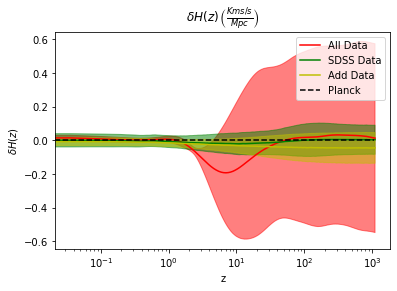

In [102]:
plt.plot(z_arr,  dH_All_m, color ='r', label='All Data')
plt.fill_between(z_arr, dH_All_m+dH_All_s,
                 dH_All_m-dH_All_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_SDSS_m, color ='g', label='SDSS Data')
plt.fill_between(z_arr, dH_SDSS_m+dH_SDSS_s, 
                 dH_SDSS_m-dH_SDSS_s, color='g', alpha=.5)

plt.plot(z_arr,  dH_Add_m, color ='y', label='Add Data')
plt.fill_between(z_arr, dH_Add_m+dH_Add_s,
                 dH_Add_m-dH_Add_s, color='y', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

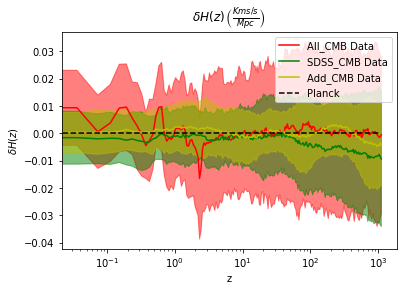

In [103]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='All_CMB Data')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_SDSS_CMB_m, color ='g', label='SDSS_CMB Data')
plt.fill_between(z_arr, dH_SDSS_CMB_m+dH_SDSS_CMB_s, 
                 dH_SDSS_CMB_m-dH_SDSS_CMB_s, color='g', alpha=.5)

plt.plot(z_arr,  dH_Add_CMB_m, color ='y', label='Add_CMB Data')
plt.fill_between(z_arr, dH_Add_CMB_m+dH_Add_CMB_s,
                 dH_Add_CMB_m-dH_Add_CMB_s, color='y', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

# H gp 

In [40]:
H_DESI_m, H_DESI_s = get_m_s(DESI['Hz'])
H_DESI_CMB_m, H_DESI_CMB_s = get_m_s(DESI_CMB['Hz'])
H_All_m, H_All_s = get_m_s(All['Hz'])
H_All_CMB_m, H_All_CMB_s = get_m_s(All_CMB['Hz'])
H_All_CMB_hp_m, H_All_CMB_hp_s = get_m_s(All_CMB_hp['Hz'])
H_All_CMB_geo_gro_m, H_All_CMB_geo_gro_s = get_m_s(All_CMB_geo_gro['Hz'])
H_All_FCMB_m, H_All_FCMB_s = get_m_s(All_FCMB['Hz'])
H_SDSS_m, H_SDSS_s = get_m_s(SDSS['Hz'])
H_SDSS_CMB_m, H_SDSS_CMB_s = get_m_s(SDSS_CMB['Hz'])
H_Add_m, H_Add_s = get_m_s(Add['Hz'])
H_Add_CMB_m, H_Add_CMB_s = get_m_s(Add_CMB['Hz'])

H_All_mean_m, H_All_mean_s = get_m_s(All_mean['Hz'])
H_All_CMB_mean_m, H_All_CMB_mean_s = get_m_s(All_CMB_mean['Hz'])
H_All_osc_m, H_All_osc_s = get_m_s(All_osc['Hz'])
H_All_CMB_osc_m, H_All_CMB_osc_s = get_m_s(All_CMB_osc['Hz'])

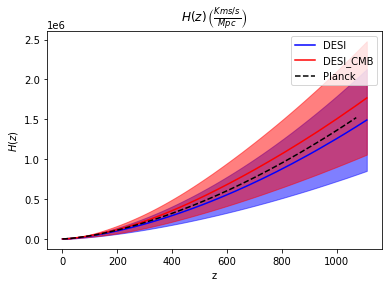

In [41]:
plt.plot(z_arr,  H_DESI_m, color ='b', label='DESI')
plt.fill_between(z_arr, H_DESI_m+H_DESI_s,
                 H_DESI_m-H_DESI_s, color='b', alpha=.5)
plt.plot(z_arr,  H_DESI_CMB_m, color ='r', label='DESI_CMB')
plt.fill_between(z_arr, H_DESI_CMB_m+H_DESI_CMB_s,
                 H_DESI_CMB_m-H_DESI_CMB_s, color='r', alpha=.5)

plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

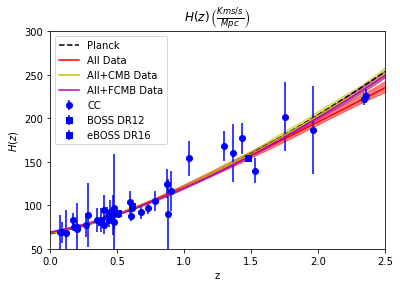

In [42]:
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='bo', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='bs', label='eBOSS DR16')

plt.plot(z_arr,  H_All_m, color ='r', label='All Data')
plt.fill_between(DESI_CMB['z_arr'], H_All_m+H_All_s, H_All_m-H_All_s, color='r', alpha=.5)
plt.plot(z_arr,  H_All_CMB_m, color ='y', label='All+CMB Data')
plt.fill_between(DESI_CMB['z_arr'], H_All_CMB_m+H_All_CMB_s, H_All_CMB_m-H_All_CMB_s, color='y', alpha=.5)
plt.plot(z_arr,  H_All_FCMB_m, color ='m', label='All+FCMB Data')
plt.fill_between(DESI_CMB['z_arr'], H_All_FCMB_m+H_All_FCMB_s,
                 H_All_FCMB_m-H_All_FCMB_s, color='m', alpha=.5)


# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')  

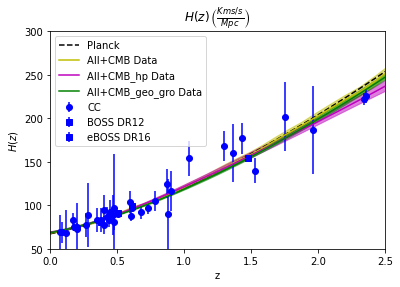

In [43]:
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='bo', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='bs', label='eBOSS DR16')

plt.plot(z_arr,  H_All_CMB_m, color ='y', label='All+CMB Data')
plt.fill_between(z_arr, H_All_CMB_m+H_All_CMB_s, H_All_CMB_m-H_All_CMB_s, color='y', alpha=.5)
plt.plot(z_arr,  H_All_CMB_hp_m, color ='m', label='All+CMB_hp Data')
plt.fill_between(z_arr, H_All_CMB_hp_m+H_All_CMB_hp_s,
                 H_All_CMB_hp_m-H_All_CMB_hp_s, color='m', alpha=.5)
plt.plot(z_arr,  H_All_CMB_geo_gro_m, color ='g', label='All+CMB_geo_gro Data')
plt.fill_between(z_arr, H_All_CMB_geo_gro_m+H_All_CMB_geo_gro_s,
                 H_All_CMB_geo_gro_m-H_All_CMB_geo_gro_s, color='g', alpha=.5)
plt.plot(z_arr,  H_All_CMB_geo_gro_m, color ='g', label='All+CMB_full Data')
plt.fill_between(z_arr, H_All_CMB_geo_gro_m+H_All_CMB_geo_gro_s,
                 H_All_CMB_geo_gro_m-H_All_CMB_geo_gro_s, color='g', alpha=.5)
plt.plot(z_arr,  H_All_CMB_geo_gro_m, color ='g', label='All+CMB_Xi Data')
plt.fill_between(z_arr, H_All_CMB_geo_gro_m+H_All_CMB_geo_gro_s,
                 H_All_CMB_geo_gro_m-H_All_CMB_geo_gro_s, color='g', alpha=.5)
# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')  

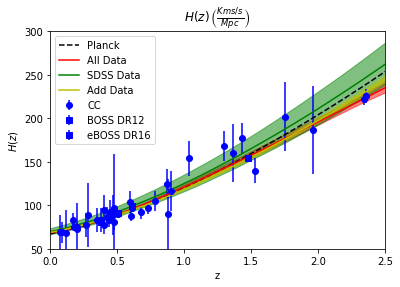

In [44]:
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='bo', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='bs', label='eBOSS DR16')

plt.plot(z_arr,  H_All_m, color ='r', label='All Data')
plt.fill_between(z_arr, H_All_m+H_All_s, H_All_m-H_All_s, color='r', alpha=.5)

plt.plot(z_arr,  H_SDSS_m, color ='g', label='SDSS Data')
plt.fill_between(z_arr, H_SDSS_m+H_SDSS_s, H_SDSS_m-H_SDSS_s, color='g', alpha=.5)

plt.plot(z_arr,  H_Add_m, color ='y', label='Add Data')
plt.fill_between(z_arr, H_Add_m+H_Add_s, H_Add_m-H_Add_s, color='y', alpha=.5)

# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')  

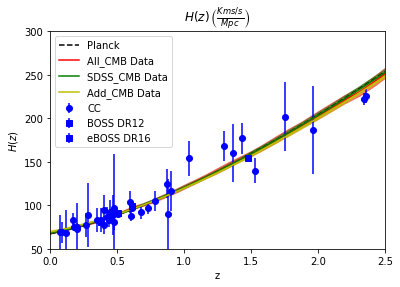

In [109]:
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='bo', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='bs', label='eBOSS DR16')

plt.plot(z_arr,  H_All_CMB_m, color ='r', label='All_CMB Data')
plt.fill_between(z_arr, H_All_CMB_m+H_All_CMB_s,
                 H_All_CMB_m-H_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  H_SDSS_CMB_m, color ='g', label='SDSS_CMB Data')
plt.fill_between(z_arr, H_SDSS_CMB_m+H_SDSS_CMB_s, 
                 H_SDSS_CMB_m-H_SDSS_CMB_s, color='g', alpha=.5)

plt.plot(z_arr,  H_Add_CMB_m, color ='y', label='Add_CMB Data')
plt.fill_between(z_arr, H_Add_CMB_m+H_Add_CMB_s,
                 H_Add_CMB_m-H_Add_CMB_s, color='y', alpha=.5)

# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')  

# dM

In [130]:
dM_DESI_m, dM_DESI_s = get_m_s(DESI['dMz'])
dM_DESI_CMB_m, dM_DESI_CMB_s = get_m_s(DESI_CMB['dMz'])
dM_All_m, dM_All_s = get_m_s(All['dMz'])
dM_All_CMB_m, dM_All_CMB_s = get_m_s(All_CMB['dMz'])
dM_All_CMB_hp_m, dM_All_CMB_hp_s = get_m_s(All_CMB_hp['dMz'])
dM_All_CMB_geo_gro_m, dM_All_CMB_geo_gro_s = get_m_s(All_CMB_geo_gro['dMz'])
dM_All_FCMB_m, dM_All_FCMB_s = get_m_s(All_FCMB['dMz'])
dM_SDSS_m, dM_SDSS_s = get_m_s(SDSS['dMz'])
dM_SDSS_CMB_m, dM_SDSS_CMB_s = get_m_s(SDSS_CMB['dMz'])
dM_Add_m, dM_Add_s = get_m_s(Add['dMz'])
dM_Add_CMB_m, dM_Add_CMB_s = get_m_s(Add_CMB['dMz'])

dM_All_mean_m, dM_All_mean_s = get_m_s(All_mean['dMz'])
dM_All_CMB_mean_m, dM_All_CMB_mean_s = get_m_s(All_CMB_mean['dMz'])

dM_All_osc_m, dM_All_osc_s = get_m_s(All_osc['dMz'])
dM_All_CMB_osc_m, dM_All_CMB_osc_s = get_m_s(All_CMB_osc['dMz'])

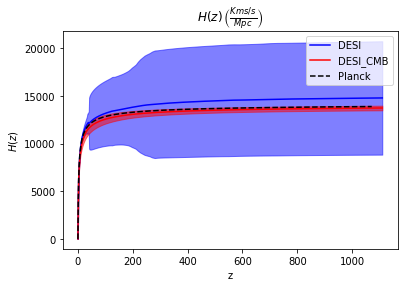

In [113]:
plt.plot(z_arr,  dM_DESI_m, color ='b', label='DESI')
plt.fill_between(z_arr, dM_DESI_m+dM_DESI_s,
                 dM_DESI_m-dM_DESI_s, color='b', alpha=.5)

plt.plot(z_arr,  dM_DESI_CMB_m, color ='r', label='DESI_CMB')
plt.fill_between(z_arr, dM_DESI_CMB_m+dM_DESI_CMB_s,
                 dM_DESI_CMB_m-dM_DESI_CMB_s, color='r', alpha=.5)


plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

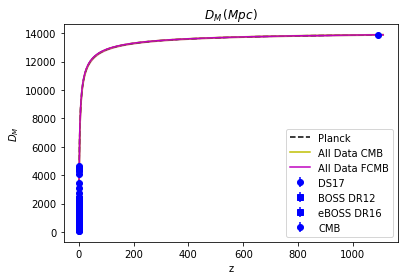

In [128]:
plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='bo', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='bs', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='bo', label='CMB')

#plt.plot(z_arr,  dM_All_m, color ='r', label='All Data')
#plt.fill_between(z_arr, dM_All_m+dM_All_s, dM_All_m-dM_All_s, color='r', alpha=.5)
plt.plot(z_arr,  dM_All_CMB_m, color ='y', label='All Data CMB')
plt.fill_between(z_arr, dM_All_CMB_m+dM_All_CMB_s, dM_All_CMB_m-dM_All_CMB_s, color='y', alpha=.5)
plt.plot(z_arr,  dM_All_FCMB_m, color ='m', label='All Data FCMB')
plt.fill_between(z_arr, dM_All_FCMB_m+dM_All_FCMB_s,
                 dM_All_FCMB_m-dM_All_FCMB_s, color='m', alpha=.5)

plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')  

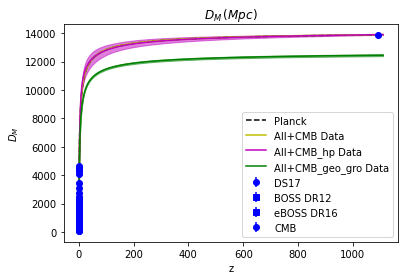

In [133]:
plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='bo', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='bs', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='bo', label='CMB')

plt.plot(z_arr,  dM_All_CMB_m, color ='y', label='All+CMB Data')
plt.fill_between(z_arr, dM_All_CMB_m+dM_All_CMB_s, dM_All_CMB_m-dM_All_CMB_s, color='y', alpha=.5)
plt.plot(z_arr,  dM_All_CMB_hp_m, color ='m', label='All+CMB_hp Data')
plt.fill_between(z_arr, dM_All_CMB_hp_m+dM_All_CMB_hp_s,
                 dM_All_CMB_hp_m-dM_All_CMB_hp_s, color='m', alpha=.5)
plt.plot(z_arr,  dM_All_CMB_geo_gro_m, color ='g', label='All+CMB_geo_gro Data')
plt.fill_between(z_arr, dM_All_CMB_geo_gro_m+dM_All_CMB_geo_gro_s,
                 dM_All_CMB_geo_gro_m-dM_All_CMB_geo_gro_s, color='g', alpha=.5)

plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')  

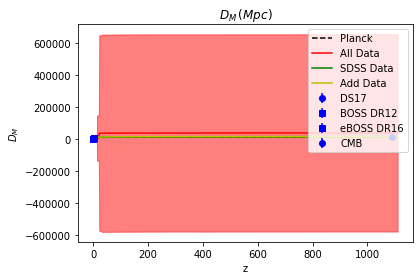

In [115]:
plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='bo', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='bs', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='bo', label='CMB')

plt.plot(z_arr,  dM_All_m, color ='r', label='All Data')
plt.fill_between(z_arr, dM_All_m+dM_All_s, dM_All_m-dM_All_s, color='r', alpha=.5)
plt.plot(z_arr,  dM_SDSS_m, color ='g', label='SDSS Data')
plt.fill_between(z_arr, dM_SDSS_m+dM_SDSS_s, dM_SDSS_m-dM_SDSS_s, color='g', alpha=.5)
plt.plot(z_arr,  dM_Add_m, color ='y', label='Add Data')
plt.fill_between(z_arr, dM_Add_m+dM_Add_s, dM_Add_m-dM_Add_s, color='y', alpha=.5)


plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')  

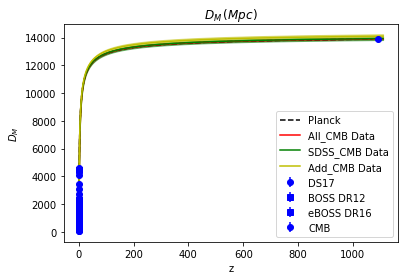

In [116]:
plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='bo', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='bs', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='bo', label='CMB')

plt.plot(z_arr,  dM_All_CMB_m, color ='r', label='All_CMB Data')
plt.fill_between(z_arr, dM_All_CMB_m+dM_All_CMB_s,
                 dM_All_CMB_m-dM_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  dM_SDSS_CMB_m, color ='g', label='SDSS_CMB Data')
plt.fill_between(z_arr, dM_SDSS_CMB_m+dM_SDSS_CMB_s,
                 dM_SDSS_CMB_m-dM_SDSS_CMB_s, color='g', alpha=.5)
plt.plot(z_arr,  dM_Add_CMB_m, color ='y', label='Add_CMB Data')
plt.fill_between(z_arr, dM_Add_CMB_m+dM_Add_CMB_s,
                 dM_Add_CMB_m-dM_Add_CMB_s, color='y', alpha=.5)


plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')  

# fs8

In [46]:
fs8_DESI_m, fs8_DESI_s = get_m_s(DESI['fs8z'])
fs8_DESI_CMB_m, fs8_DESI_CMB_s = get_m_s(DESI_CMB['fs8z'])
fs8_All_m, fs8_All_s = get_m_s(All['fs8z'])
fs8_All_CMB_m, fs8_All_CMB_s = get_m_s(All_CMB['fs8z'])
fs8_All_CMB_full_m, fs8_All_CMB_full_s = get_m_s(All_CMB_full['fs8z'])
fs8_All_CMB_geo_gro_m, fs8_All_CMB_geo_gro_s = get_m_s(All_CMB_geo_gro['fs8z'])
fs8_All_CMB_hp_m, fs8_All_CMB_hp_s = get_m_s(All_CMB_hp['fs8z'])
fs8_All_CMB_Xi_m, fs8_All_CMB_Xi_s = get_m_s(All_CMB_Xi['fs8z'])
fs8_All_FCMB_m, fs8_All_FCMB_s = get_m_s(All_FCMB['fs8z'])
fs8_SDSS_m, fs8_SDSS_s = get_m_s(SDSS['fs8z'])
fs8_SDSS_CMB_m, fs8_SDSS_CMB_s = get_m_s(SDSS_CMB['fs8z'])
fs8_Add_m, fs8_Add_s = get_m_s(Add['fs8z'])
fs8_Add_CMB_m, fs8_Add_CMB_s = get_m_s(Add_CMB['fs8z'])

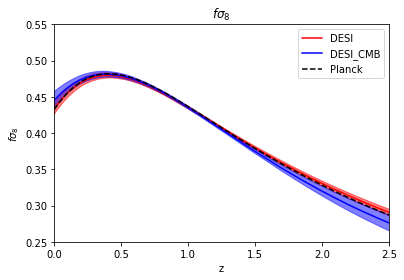

In [120]:
plt.plot(z_arr,  fs8_DESI_m, color ='r', label='DESI')
plt.fill_between(z_arr, fs8_DESI_m+fs8_DESI_s,
                 fs8_DESI_m-fs8_DESI_s, color='r', alpha=.5)
plt.plot(z_arr,  fs8_DESI_CMB_m, color ='b', label='DESI_CMB')
plt.fill_between(z_arr, fs8_DESI_CMB_m+fs8_DESI_CMB_s,
                 fs8_DESI_CMB_m-fs8_DESI_CMB_s, color='b', alpha=.5)

plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')


plt.xlim(0, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

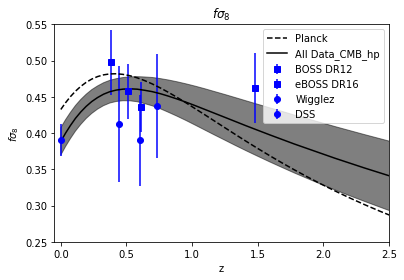

In [55]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='bs', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='bo', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='bo', label='DSS')


#plt.plot(z_arr,  fs8_All_CMB_full_m, color ='b', label='All Data_CMB_full')
#plt.fill_between(z_arr, fs8_All_CMB_full_m+fs8_All_CMB_full_s,
#                 fs8_All_CMB_full_m-fs8_All_CMB_full_s, color='b', alpha=.5)
#plt.plot(z_arr,  fs8_All_CMB_geo_gro_m, color ='m', label='All Data_CMB_geo_gro')
#plt.fill_between(z_arr, fs8_All_CMB_geo_gro_m+fs8_All_CMB_geo_gro_s,
#                 fs8_All_CMB_geo_gro_m-fs8_All_CMB_geo_gro_s, color='m', alpha=.5)
#plt.plot(z_arr,  fs8_All_CMB_Xi_m, color ='g', label='All Data_CMB_Xi')
#plt.fill_between(z_arr, fs8_All_CMB_Xi_m+fs8_All_CMB_Xi_s,
#                 fs8_All_CMB_Xi_m-fs8_All_CMB_Xi_s, color='g', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_hp_m, color ='k', label='All Data_CMB_hp')
plt.fill_between(z_arr, fs8_All_CMB_hp_m+fs8_All_CMB_hp_s,
                 fs8_All_CMB_hp_m-fs8_All_CMB_hp_s, color='k', alpha=.5)
#plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='All Data_CMB')
#plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_CMB_s,
#                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)

plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_data.pdf')  

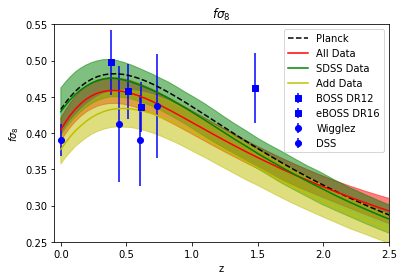

In [47]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='bs', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='bo', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='bo', label='DSS')

plt.plot(z_arr,  fs8_All_m, color ='r', label='All Data')
plt.fill_between(z_arr, fs8_All_m+fs8_All_s, fs8_All_m-fs8_All_s, color='r', alpha=.5)
plt.plot(z_arr,  fs8_SDSS_m, color ='g', label='SDSS Data')
plt.fill_between(z_arr, fs8_SDSS_m+fs8_SDSS_s, fs8_SDSS_m-fs8_SDSS_s, color='g', alpha=.5)
plt.plot(z_arr,  fs8_Add_m, color ='y', label='Add Data')
plt.fill_between(z_arr, fs8_Add_m+fs8_Add_s, fs8_Add_m-fs8_Add_s, color='y', alpha=.5)

plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_data.pdf')  

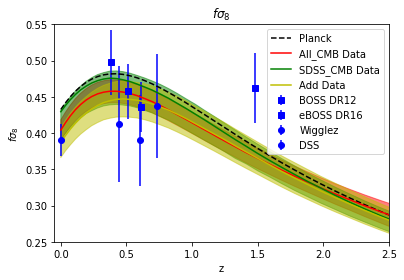

In [48]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='bs', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='bo', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='bo', label='DSS')

plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='All_CMB Data')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_CMB_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  fs8_SDSS_m, color ='g', label='SDSS_CMB Data')
plt.fill_between(z_arr, fs8_SDSS_CMB_m+fs8_SDSS_CMB_s,
                 fs8_SDSS_CMB_m-fs8_SDSS_CMB_s, color='g', alpha=.5)
plt.plot(z_arr,  fs8_Add_CMB_m, color ='y', label='Add Data')
plt.fill_between(z_arr, fs8_Add_CMB_m+fs8_Add_CMB_s,
                 fs8_Add_CMB_m-fs8_Add_CMB_s, color='y', alpha=.5)

plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_data.pdf')  